<a href="https://colab.research.google.com/github/satyajitghana/TSAI-DeepVision-EVA4.0/blob/master/Utils/Colab_25GBRAM_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Memory Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 24.54GB
Used: 634.74MB
Percentage: 3.8%


# GPU Information

In [ ]:
! nvidia-smi

Sat May 16 10:39:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls drive/My\ Drive/ML-work/Okulo\ aerospace/Land\ cover\ classification

Data/  models/  test_feature_deepsat_6.csv  train_feature_deepstat_6.csv


In [ ]:
cd drive/My\ Drive/ML-work/Okulo\ aerospace/Land\ cover\ classification

/content/drive/My Drive/ML-work/Okulo aerospace/Land cover classification


In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
from skimage import color
!pip install mahotas
import mahotas as mt
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./train_feature_deepstat_6.csv
./test_feature_deepsat_6.csv
./Data/X_test_sat6.csv
./Data/X_train_sat6.csv
./Data/y_train_sat6.csv
./Data/sat6annotations.csv
./Data/y_test_sat6.csv
./models/trained_model.json
./models/model.h5


In [ ]:
train_data_path="./Data/X_train_sat6.csv"
train_label_path="./Data/y_train_sat6.csv"
test_data_path="./Data/X_test_sat6.csv"
test_lable_path="./Data/y_test_sat6.csv"

In [ ]:
def data_read(data_path, nrows):
    data=pd.read_csv(data_path, header=None, nrows=nrows)
    data=data.values ## converting the data into numpy array
    return data

In [ ]:
##Read training data
train_data=data_read(train_data_path, nrows=500)
print("Train data shape:" + str(train_data.shape))

##Read training data labels
train_data_label=data_read(train_label_path,nrows=500)
print("Train data label shape:" + str(train_data_label.shape))
print()

##Read test data
test_data=data_read(test_data_path, nrows=100)
print("Test data shape:" + str(test_data.shape))


##Read test data labels
test_data_label=data_read(test_lable_path,nrows=100)
print("Test data label shape:" + str(test_data_label.shape))

Train data shape:(500, 3136)
Train data label shape:(500, 6)

Test data shape:(100, 3136)
Test data label shape:(100, 6)


In [ ]:
def label_conv(label_arr):
    labels=[]
    for i in range(len(label_arr)):
        
        if (label_arr[i]==[1,0,0,0,0,0]).all():
            labels.append("Building")  
            
        elif (label_arr[i]==[0,1,0,0,0,0]).all():  
            labels.append("Barren_land")  
            
        elif (label_arr[i]==[0,0,1,0,0,0]).all():
            labels.append("Tree") 
            
        elif (label_arr[i]==[0,0,0,1,0,0]).all():
            labels.append("Grassland")
            
        elif (label_arr[i]==[0,0,0,0,1,0]).all():
            labels.append("Road") 
            
        else:
            labels.append("Water")
    return labels
train_label_convert=label_conv(train_data_label)##train label conveter
test_label_convert=label_conv(test_data_label) ##test label converter


def data_visualization(data, label, n):
    ##data: training or test data
    ##label: training or test labels
    ## n: number of data point, it should be less than or equal to no. of data points
    fig = plt.figure(figsize=(14, 14))
    ax = []  # ax enables access to manipulate each of subplots
    rows, columns=4,4
    for i in range(columns*rows):
        index=np.random.randint(1,n)
        img= data[index].reshape([28,28,4])[:,:,:3] ##reshape input data to rgb image
        ax.append( fig.add_subplot(rows, columns, i+1) ) # create subplot and append to ax
        ax[-1].set_title("Class:"+str(label[index]))  # set class
        plt.axis("off")
        plt.imshow(img)

    plt.subplots_adjust(wspace=0.1,hspace=0.5)
    plt.show()  # finally, render the plot

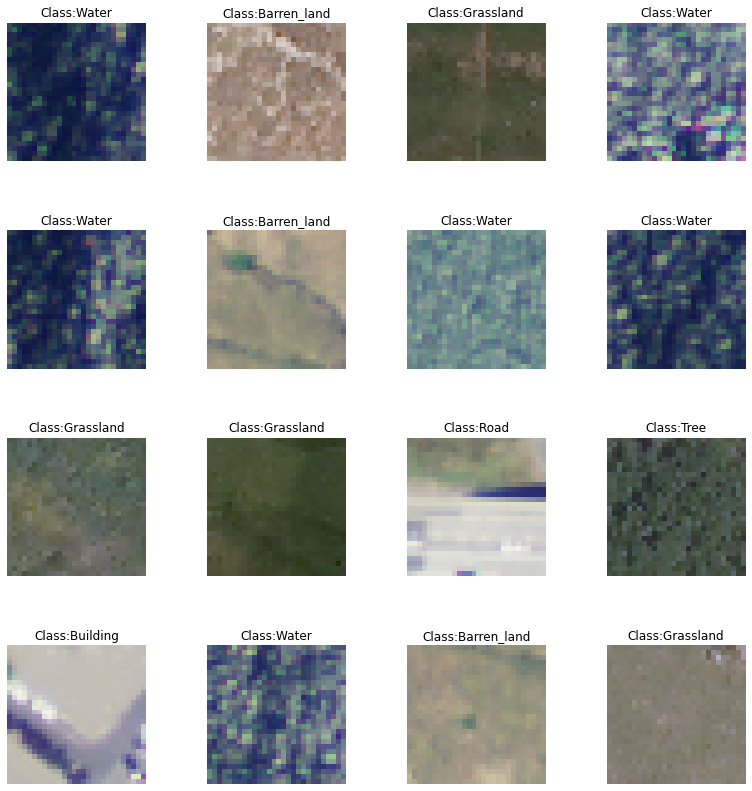

In [ ]:
data_visualization(train_data,train_label_convert, n=500)

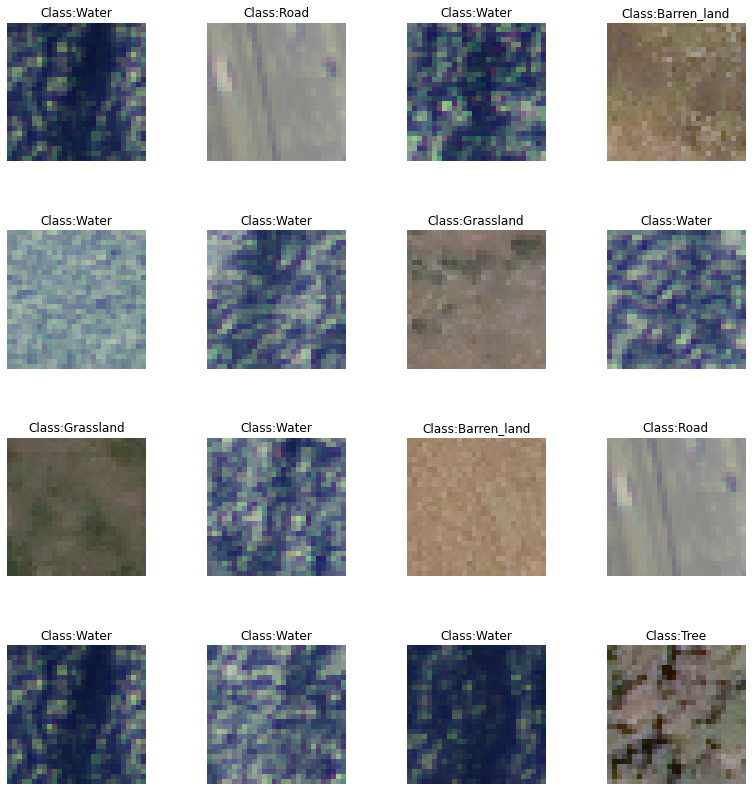

In [ ]:
data_visualization(test_data,test_label_convert, n=100)

In [ ]:
def feature_extractor(input_image_file):
    
        tex_feature=[]
        hsv_feature=[]
        ndvi_feature=[]
        arvi_feature=[]

        for df_chunk in pd.read_csv(input_image_file ,header=None,chunksize = 50000):

            df_chunk=df_chunk.astype("int32")
            data=df_chunk.values
            print(len(data))

            ################data for HSV and Texture feature##############
            img=data.reshape(-1,28,28,4)[:,:,:,:3]
            #############################################################

            ######################Data for NDVI and ARVI#################

            NIR=data.reshape(-1,28,28,4)[:,:,:,3]
            Red=data.reshape(-1,28,28,4)[:,:,:,2]
            Blue=data.reshape(-1,28,28,4)[:,:,:,0]
            #############################################################

            for i in range(len(data)):

                #######Texture_feature####################################
                textures = mt.features.haralick(img[i])
                ht_mean= textures.mean(axis=0)
                tex_feature.append(ht_mean)
                ##########################################################

                #######hsv_feature#########################################
                img_hsv = color.rgb2hsv(img[i]) # Image into HSV colorspace
                h = img_hsv[:,:,0] # Hue
                s = img_hsv[:,:,1] # Saturation
                v = img_hsv[:,:,2] # Value aka Lightness
                hsv_feature.append((h.mean(),s.mean(),v.mean()))
                ###########################################################

                ##########Calculation of NDVI Feature######################
                NDVI=(NIR[i]-Red[i])/(NIR[i]+Red[i])
                ndvi_feature.append(NDVI.mean())
                ############################################################

                ###################Calculation of ARVI#####################
                a_1=NIR[i] -(2*Red[i]-Blue[i])
                a_2=NIR[i] +(2*Red[i]+Blue[i])
                arvi=a_1/a_2
                arvi_feature.append(arvi.mean())
                #######################################################

        features=[]
        for i in range(len(tex_feature)):
            h_stack=np.hstack((tex_feature[i], hsv_feature[i], ndvi_feature[i], arvi_feature[i]))
            features.append(h_stack)
            
        return features

In [ ]:
train_data_features=feature_extractor(train_data_path)

50000
50000
50000
50000
50000
50000
24000


In [ ]:
# saving train data features
cols=[]
for i in range(len(train_data_features[0])):
    cols.append("feature"+ str(i))
feature=pd.DataFrame(train_data_features, columns=cols)
feature.to_csv("train_feature_deepstat_6.csv")

In [ ]:
#test data features extraction
test_data_features=feature_extractor(test_data_path)

50000
31000


In [ ]:
feature_test=pd.DataFrame(test_data_features, columns=["feature"+ str(i) for i in range(len(train_data_features[0]))])
feature_test.to_csv("test_feature_deepsat_6.csv")

In [ ]:
from sklearn.preprocessing import StandardScaler 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from time import time
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [ ]:
def data_read_(data_path):
    df=pd.read_csv(data_path, index_col=[0])
    return df

def label_read(data_path):
    df=pd.read_csv(data_path, header=None)
    return df

In [ ]:
train_feature_deepstat_6=data_read_(data_path="./train_feature_deepstat_6.csv")
train_label=label_read(data_path=train_label_path)
print("Training data shape: ",train_feature_deepstat_6.shape)
print("Training label shape: ",train_label.shape)

Training data shape:  (324000, 18)
Training label shape:  (324000, 6)


In [ ]:
train_feature_deepstat_6.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17
0,0.000510,617.467448,0.744604,1208.225664,0.075734,165.287322,4215.435207,7.637573,11.158415,0.000144,5.546250,-0.356272,0.995773,0.365449,0.207631,4.211562e-08,0.130287,0.082918
1,0.001207,417.651225,0.397474,373.466474,0.082166,321.815240,1076.214670,6.722432,10.047084,0.000350,4.048463,-0.345718,0.991588,0.090416,0.258090,8.581116e-08,0.136626,0.142940
2,0.000398,1943.661871,0.403912,1619.892120,0.041302,156.599515,4535.906611,7.854340,11.419267,0.000051,6.343184,-0.394795,0.998089,0.599307,0.510874,5.071253e-08,-0.762366,-0.488413
3,0.000410,1016.512108,0.571321,1181.209671,0.048341,160.536238,3708.326575,7.776289,11.377842,0.000085,5.898673,-0.375375,0.997312,0.579702,0.435979,4.884989e-08,-0.779538,-0.482682
4,0.000647,487.816884,0.296176,345.964345,0.067422,288.690819,896.040495,6.823493,10.881089,0.000118,5.422547,-0.235495,0.972060,0.516917,0.193726,7.365289e-08,-0.659481,-0.320696


In [ ]:
train_label.head()

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1


In [ ]:
test_feature_deepsat_6=data_read_(data_path="./test_feature_deepsat_6.csv")
test_label=label_read(data_path=test_lable_path)
print("Training data shape: ",test_feature_deepsat_6.shape)
print("Training label shape: ",test_label.shape)

Training data shape:  (81000, 18)
Training label shape:  (81000, 6)


In [ ]:
test_feature_deepsat_6.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17
0,0.000472,825.146019,0.483915,799.436334,0.054771,163.380355,2372.599315,7.433824,11.232332,0.000107,5.772372,-0.321464,0.992508,0.342550,0.203484,4.158225e-08,0.300045,0.188149
1,0.000747,450.118996,0.520765,468.906282,0.082015,203.764809,1425.506132,7.055624,10.791574,0.000153,5.301941,-0.278724,0.983755,0.203896,0.131008,5.035616e-08,0.235854,0.156365
2,0.000375,1244.129580,0.599170,1543.860577,0.041937,224.183576,4931.312727,7.980644,11.476607,0.000063,6.082126,-0.409750,0.998548,0.565407,0.333206,6.285180e-08,-0.672770,-0.387071
3,0.001382,388.768318,0.387355,330.283150,0.064144,272.052422,932.364281,6.665846,9.931245,0.000168,4.945995,-0.221024,0.951162,0.068662,0.239222,7.308982e-08,0.243074,0.193786
4,0.000713,435.000939,0.467699,418.204251,0.071743,111.584020,1237.816065,6.963757,10.728918,0.000235,5.109433,-0.268148,0.980983,0.599072,0.514390,3.666192e-08,-0.841739,-0.561151


In [ ]:
test_label.head()

,0,1,2,3,4,5
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,1,0,0,0,0
4,0,0,0,0,0,1


In [ ]:
sc=StandardScaler()
#fit the training data
fit=sc.fit(train_feature_deepstat_6)

In [ ]:
##transform the train and test data
train_data_stn=fit.transform(train_feature_deepstat_6)
test_data_stn=fit.transform(test_feature_deepsat_6)

In [ ]:
model=Sequential()

#layer1
model.add(Dense(units=50,input_shape=(train_data_stn.shape[1],),use_bias=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

#layer2
model.add(Dense(units=50, use_bias=True))
#model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.2))

#layer3
model.add(Dense(units=6, activation="softmax"))


##ADD early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
# mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))
#tensorboard=TensorBoard(log_dir='logs/{}'.format(time()))

#compile the model
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#model.fit(train_data_stn, train_label.values, validation_split=0.15, batch_size=512, epochs=500,callbacks=[es, mc,tensorboard]) 
model.fit(train_data_stn, train_label.values, validation_split=0.15, batch_size=512, epochs=70,callbacks=[es]) 

Train on 275400 samples, validate on 48600 samples
Epoch 1/70
275400/275400 [==============================] - 2s 8us/step - loss: 0.2662 - accuracy: 0.9166 - val_loss: 0.0858 - val_accuracy: 0.9716
Epoch 2/70
275400/275400 [==============================] - 2s 6us/step - loss: 0.0966 - accuracy: 0.9675 - val_loss: 0.0684 - val_accuracy: 0.9760
Epoch 3/70
275400/275400 [==============================] - 2s 7us/step - loss: 0.0810 - accuracy: 0.9725 - val_loss: 0.0610 - val_accuracy: 0.9784
Epoch 4/70
275400/275400 [==============================] - 2s 7us/step - loss: 0.0726 - accuracy: 0.9755 - val_loss: 0.0547 - val_accuracy: 0.9808
Epoch 5/70
275400/275400 [==============================] - 2s 6us/step - loss: 0.0663 - accuracy: 0.9776 - val_loss: 0.0509 - val_accuracy: 0.9819
Epoch 6/70
275400/275400 [==============================] - 2s 7us/step - loss: 0.0620 - accuracy: 0.9790 - val_loss: 0.0472 - val_accuracy: 0.9836
Epoch 7/70
275400/275400 [==============================] - 2

In [ ]:
Accuracy_on_test_data=model.evaluate(test_data_stn, test_label.values)[1]
print("Accuracy on test data: ",Accuracy_on_test_data)

81000/81000 [==============================] - 4s 44us/step
Accuracy on test data:  0.9945926070213318


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("trained_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
import mlxtend                                                          
print(mlxtend.__version__)   

0.17.2


In [ ]:
!pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3MB 2.8MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


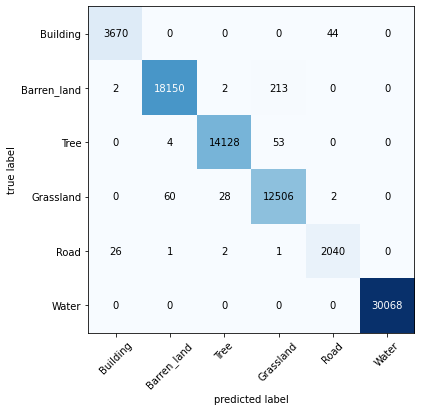

In [ ]:
# [1,0,0,0,0,0]=building
# [0,1,0,0,0]=barren_land
# [0,0,1,0,0,0]=tree
# [0,0,0,1,0,0]=grassland
# [0,0,0,0,1,0]=road
# [0,0,0,0,0,1]=water


##Building confusion matrix

y_pred=model.predict_classes(test_data_stn)
y_true=np.argmax(test_label.values, axis=1)
cm=confusion_matrix(y_target=y_true, y_predicted=y_pred)

plot_confusion_matrix(cm,class_names=["Building","Barren_land","Tree","Grassland","Road","Water"],figsize=(6,6) )
plt.show()

In [ ]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)

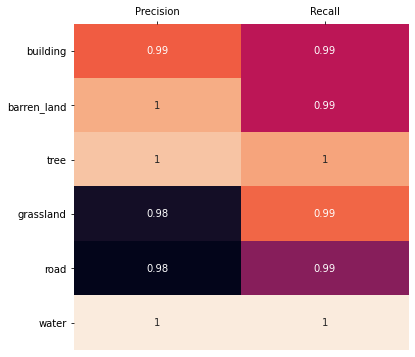

In [ ]:
dic={}
precision_=[]
recall_=[]
precision_macro_average_=[]
for label in range(6):
    precision_.append(precision(label, cm))
    recall_.append(recall(label, cm))
    
dic["Precision"]= precision_
dic["Recall"]= recall_

plt.figure(figsize=(6,6))
ax=sns.heatmap(pd.DataFrame(dic, index=["building","barren_land","tree","grassland","road","water"]),annot=True,cbar=False)
plt.yticks(rotation=0)
ax.xaxis.tick_top() # x axis on top

plt.show()